In [40]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

In [2]:
from cosmoNODE import utils
from cosmoNODE.loaders import LC

In [3]:
# data formatted according to https://github.com/YuliaRubanova/latent_ode/issues/2
# (record_id, observation_times, values, mask, labels)
# working on parse_dataset
fluxnet = utils.FluxNet()
curve = fluxnet.curves[0]

In [5]:
train_data, test_data = train_test_split(fluxnet.curves, train_size=0.8, random_state=42, shuffle=True)

In [6]:
record_id, tt, vals, mask, labels = train_data[0]
n_samples = len(fluxnet)
input_dim = vals.size(-1)
batch_size = 30
dataset_size_n = 100

In [25]:
mins = fluxnet.merge.min()
maxes = fluxnet.merge.max()

In [46]:
data_max = torch.tensor(maxes.values)
data_min = torch.tensor(mins.values)

In [22]:
batch_size = min(min(len(fluxnet), batch_size), dataset_size_n)
# data_min, data_max = get_data_min_max(total_dataset)

In [47]:
train_dataloader = DataLoader(train_data, batch_size= batch_size, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size = n_samples, shuffle=False)

In [48]:
for i, data in enumerate(train_dataloader):
    if i == 1:
        break
    print(data)

RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 0. Got 330 and 352 in dimension 1 at /pytorch/aten/src/TH/generic/THTensor.cpp:711

In [33]:
df = pd.read_csv('./demos/data/training_set.csv')

In [34]:
mins = df.min()
maxes = df.max()

In [35]:
torch.tensor(mins.values)

tensor([ 6.1500e+02,  5.9580e+04,  0.0000e+00, -1.1494e+06,  4.6375e-01,
         0.0000e+00], dtype=torch.float64)

In [36]:
maxes

object_id    1.307798e+08
mjd          6.067436e+04
passband     5.000000e+00
flux         2.432809e+06
flux_err     2.234069e+06
detected     1.000000e+00
dtype: float64

In [37]:
def get_data_min_max(records):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    data_min, data_max = None, None
    inf = torch.Tensor([float("Inf")])[0].to(device)

    for b, (record_id, tt, vals, mask, labels) in enumerate(records):
        n_features = vals.size(-1)

        batch_min = []
        batch_max = []
        
        for i in range(n_features):
            non_missing_vals = vals[:,i][mask[:,i] == 1]
            if len(non_missing_vals) == 0:
                batch_min.append(inf)
                batch_max.append(-inf)
            else:
                batch_min.append(torch.min(non_missing_vals))
                batch_max.append(torch.max(non_missing_vals))

        batch_min = torch.stack(batch_min)
        batch_max = torch.stack(batch_max)

        if (data_min is None) and (data_max is None):
            data_min = batch_min
            data_max = batch_max
        else:
            data_min = torch.min(data_min, batch_min)
            data_max = torch.max(data_max, batch_max)

    return data_min, data_max

In [38]:
data_min, data_max = get_data_min_max(fluxnet.curves[:30])

In [39]:
data_min, data_max

(tensor([ 6.1500e+02,  0.0000e+00, -1.1004e+03,  5.6628e-01,  0.0000e+00,
          1.8987e-01, -6.4761e+01,  1.7046e+02, -6.9806e+01,  1.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  7.0000e-03],
        dtype=torch.float64),
 tensor([4.8190e+03, 5.0000e+00, 1.8971e+03, 6.8224e+01, 1.0000e+00, 3.5981e+02,
         3.5833e+00, 3.3173e+02, 4.4318e+01, 1.0000e+00, 1.9876e+00, 2.7474e+00,
         1.1523e+00, 4.6796e+01, 2.7000e-02], dtype=torch.float64))

In [64]:
rand_t = torch.randn(5, 2, 1)

In [65]:
rand_t.size(-1)

1

In [49]:
import matplotlib.pyplot as plt

In [50]:
accs = [0.1330, 0.7314, 0.9247, 0.9638, 0.9775, 0.9781, 0.9823, 0.9870, 0.9826, 0.9880, 0.9878, 0.9903, 0.9884, 0.9914, 0.9906]
x = range(len(accs))

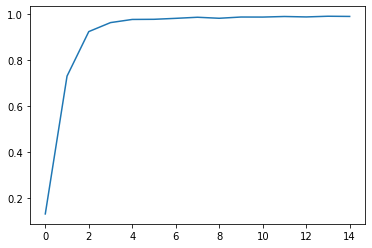

In [51]:
plt.plot(x, accs)

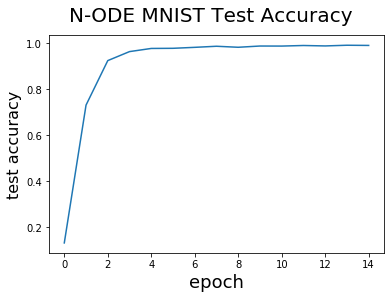

In [52]:
from matplotlib import pyplot as plt    

fig = plt.figure()
plt.plot(x, accs)
fig.suptitle('N-ODE MNIST Test Accuracy', fontsize=20)
plt.xlabel('epoch', fontsize=18)
plt.ylabel('test accuracy', fontsize=16)
fig.savefig('ode_mnist.jpg')